# Encoder Decoder

In [17]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [18]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [19]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32

loaded numpy bitmaps, 8 classes
[144722, 194843, 120527, 121661, 142167, 134680, 143570, 156883]


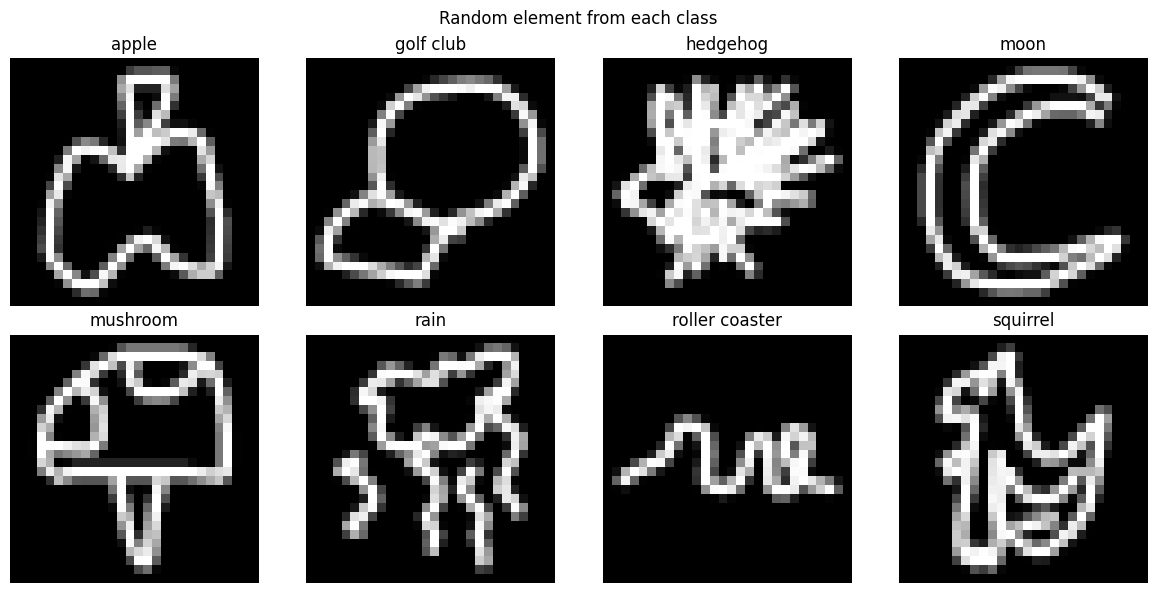

In [20]:
resources_folder = 'resources'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

classes_sizes = []

for i in range(nb_classes):
    classes_sizes.append(len(data[i]))

images = []
labels = []

# Reshape and parse data to image and labels
for i in range(nb_classes):
    for j in range(classes_sizes[i]):
        images.append(data[i][j].reshape(HEIGHT, WIDTH))
        labels.append(classes[i])

print(classes_sizes)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
# Show image for each class
for i in range(nb_classes):
    # Sum of previous classes_size
    start_index = sum(classes_sizes[:i])
    end_index = start_index + classes_sizes[i]

    # Random element from each class
    random_index = random.randint(start_index, end_index)

    axes[i // num_cols, i % num_cols].imshow(images[random_index], cmap='gray')
    axes[i // num_cols, i % num_cols].set_title(labels[random_index])
    axes[i // num_cols, i % num_cols].axis('off')
    

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

In [21]:
# Show len of train and test data
print(f'Train data: {len(images)}')
print(f'Test data: {len(labels)}')

Train data: 1159053
Test data: 1159053


In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(WIDTH * HEIGHT, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, WIDTH * HEIGHT),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [23]:
model = Autoencoder().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Too much images, take sub part (10000)
sub_dataset_size = 2000

# print percentage used
print(f'Percentage of data used: {sub_dataset_size / len(images) * 100}%')

# Suffle data and split images and labels into train and test sets
shuffler = np.random.permutation(len(images))
print(shuffler)
split_percentage = 0.8

train_images = []
train_labels = []

test_images = []
test_labels = []

for i in range(sub_dataset_size):
    if i < sub_dataset_size * split_percentage:
        train_images.append(images[shuffler[i]])
        train_labels.append(labels[shuffler[i]])
    else:
        test_images.append(images[shuffler[i]])
        test_labels.append(labels[shuffler[i]])


# Normalize data and convert to PyTorch tensors
train_normalized_images = np.array(train_images).astype(np.float32) / 255.0
train_torch_images = torch.from_numpy(train_normalized_images).to(device)

test_normalized_images = np.array(test_images).astype(np.float32) / 255.0
test_torch_images = torch.from_numpy(test_normalized_images).to(device)

print(train_labels[:20])
 

Percentage of data used: 0.1725546631603559%
[812312 236516 704004 ...   9441 652759 885403]
['rain', 'golf club', 'mushroom', 'squirrel', 'moon', 'mushroom', 'apple', 'squirrel', 'apple', 'golf club', 'roller coaster', 'moon', 'hedgehog', 'rain', 'hedgehog', 'squirrel', 'squirrel', 'golf club', 'roller coaster', 'golf club']


In [30]:
train_psnr_values = []
train_ssim_values = []

test_psnr_values = []
test_ssim_values = []

# Train the autoencoder
num_epochs = 30
batch_size = 32

for epoch in range(num_epochs):
    # Train by batch of images

    for i in range(0, len(train_torch_images), batch_size):
        batch = train_torch_images[i:i+batch_size]

        # Forward pass
        encoded, decoded = model(batch.view(-1, WIDTH * HEIGHT))
        loss = criterion(decoded, batch.view(-1, WIDTH * HEIGHT))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate PSNR and SSIM for train and test sets
    train_psnr = 0
    train_ssim = 0
    test_psnr = 0
    test_ssim = 0

    for image in train_torch_images:
        encoded, decoded = model(image.view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        image_matrix = image.cpu().detach().numpy()
        decoded_matrix = decoded.cpu().detach().numpy()[0]

        train_psnr += psnr(image_matrix, decoded_matrix)
        train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

    for image in test_torch_images:
        encoded, decoded = model(image.view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        image_matrix = image.cpu().detach().numpy()
        decoded_matrix = decoded.cpu().detach().numpy()[0]

        test_psnr += psnr(image_matrix, decoded_matrix)
        test_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())
    
    train_psnr /= len(train_torch_images)
    train_ssim /= len(train_torch_images)
    test_psnr /= len(test_torch_images)
    test_ssim /= len(test_torch_images)

    train_psnr_values.append(train_psnr)
    train_ssim_values.append(train_ssim)
    test_psnr_values.append(test_psnr)
    test_ssim_values.append(test_ssim)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}')

    

Epoch [1/30], Loss: 0.0613, Train PSNR: 12.5445, Train SSIM: 0.2990, Test PSNR: 12.1310, Test SSIM: 0.2750
Epoch [2/30], Loss: 0.0615, Train PSNR: 12.5766, Train SSIM: 0.3035, Test PSNR: 12.1473, Test SSIM: 0.2786
Epoch [3/30], Loss: 0.0616, Train PSNR: 12.5964, Train SSIM: 0.3061, Test PSNR: 12.1545, Test SSIM: 0.2804
Epoch [4/30], Loss: 0.0617, Train PSNR: 12.6105, Train SSIM: 0.3079, Test PSNR: 12.1584, Test SSIM: 0.2816
Epoch [5/30], Loss: 0.0617, Train PSNR: 12.6217, Train SSIM: 0.3096, Test PSNR: 12.1622, Test SSIM: 0.2828
Epoch [6/30], Loss: 0.0618, Train PSNR: 12.6306, Train SSIM: 0.3111, Test PSNR: 12.1653, Test SSIM: 0.2838
Epoch [7/30], Loss: 0.0618, Train PSNR: 12.6380, Train SSIM: 0.3123, Test PSNR: 12.1668, Test SSIM: 0.2847
Epoch [8/30], Loss: 0.0618, Train PSNR: 12.6457, Train SSIM: 0.3135, Test PSNR: 12.1689, Test SSIM: 0.2856
Epoch [9/30], Loss: 0.0618, Train PSNR: 12.6526, Train SSIM: 0.3146, Test PSNR: 12.1702, Test SSIM: 0.2863
Epoch [10/30], Loss: 0.0618, Train PS

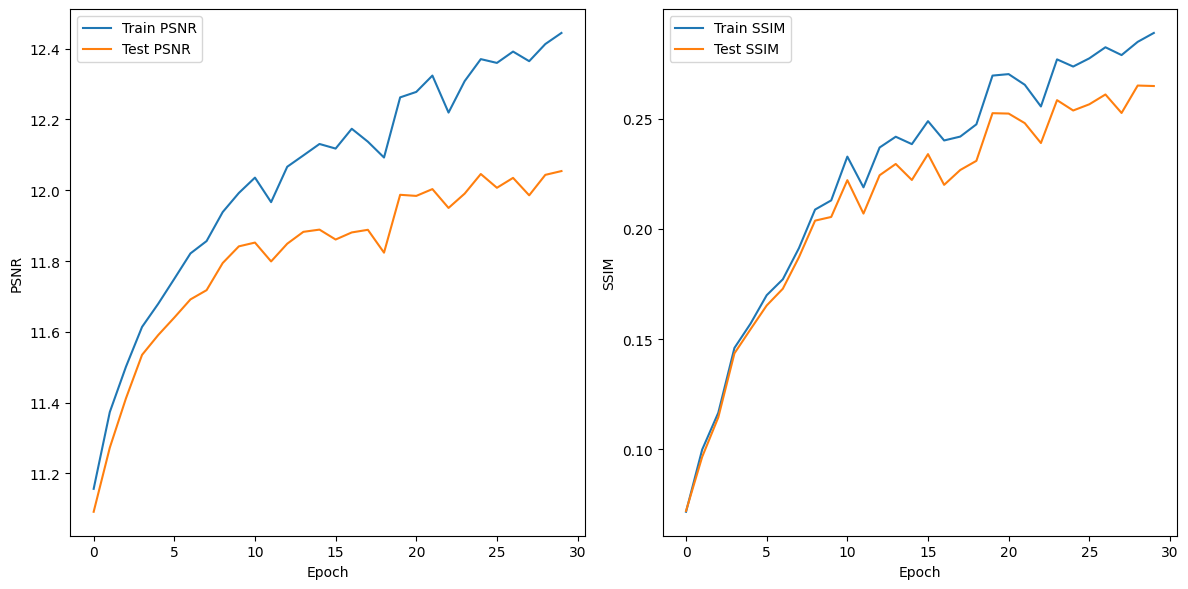

In [26]:
# Plotting Train and Test psnr on one sub plot, Train and Test ssim on another sub plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(train_psnr_values, label='Train PSNR')
axes[0].plot(test_psnr_values, label='Test PSNR')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('PSNR')
axes[0].legend()

axes[1].plot(train_ssim_values, label='Train SSIM')
axes[1].plot(test_ssim_values, label='Test SSIM')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('SSIM')
axes[1].legend()

plt.tight_layout()
plt.show()

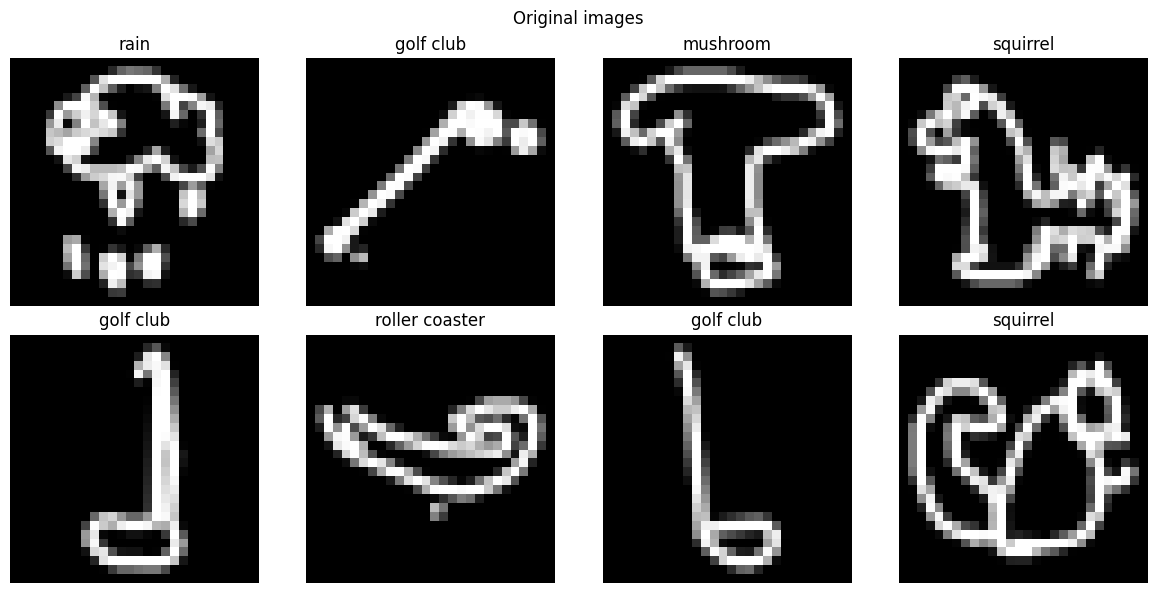

In [29]:
# Show 2 original and reconstructed images for train and 2 images for test sets
num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(num_cols):
    # Train images
    axes[0, i].imshow(train_images[i], cmap='gray')
    axes[0, i].set_title(train_labels[i])
    axes[0, i].axis('off')

    # Reconstructed images
    encoded, decoded = model(train_torch_images[i].view(-1, WIDTH * HEIGHT))
    decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

    axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
    axes[1, i].set_title(train_labels[i])
    axes[1, i].axis('off')

